In [1]:
import matplotlib.pyplot as plt
import numpy as np
import helper
import time
import datetime
import torch.nn as nn
import torchvision.models
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, models
import torchvision.utils
import torch
import pandas as pd
from torchinfo import summary
from PIL import Image
from torchvision.transforms import ToTensor
from glob import glob
from torch.utils.data import Dataset, DataLoader, random_split
from copy import copy
from collections import defaultdict
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import time
from sklearn.metrics import classification_report
from tqdm import tqdm
import math
from torcheval.metrics import BinaryAccuracy
import os
import timm
import segmentation_models_pytorch as smp
import random
from sklearn.model_selection import train_test_split
from transformers import SegformerImageProcessor, AutoModelForSemanticSegmentation
device = torch.device("cuda:4" if torch.cuda.is_available() else "cpu")
batch_size=2
img_size=1024
class_list=['NT_epithelial','NT_stroma']
tf = ToTensor()
topilimage = torchvision.transforms.ToPILImage()
def expand2square(pil_img, background_color):
    width, height = pil_img.size
    if width == height:
        return pil_img
    elif width > height:
        result = Image.new(pil_img.mode, (width, width), background_color)
        result.paste(pil_img, (0, (width - height) // 2))
        return result
    else:
        result = Image.new(pil_img.mode, (height, height), background_color)
        result.paste(pil_img, ((height - width) // 2, 0))
        return result

2024-08-05 15:30:55.441283: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-05 15:30:56.264561: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
img_path='../../data/area_segmentation/BRNT/image/'
img_list=glob(img_path+'*.jpeg')
mask_list=[i.replace('/image/','/mask/npy/') for i in img_list]
mask_list=[i.replace('.jpeg','.npy') for i in mask_list]
train_img_list,test_img_list,train_mask_list,test_mask_list=train_test_split(img_list,mask_list,test_size=0.2,random_state=42)

test_image=torch.zeros((len(test_img_list),3,img_size,img_size))
test_mask=torch.zeros((len(test_img_list),len(class_list)+1,img_size,img_size),dtype=torch.float32)    
train_image=torch.zeros((len(train_img_list),3,img_size,img_size))
train_mask=torch.zeros((len(train_img_list),len(class_list)+1,img_size,img_size),dtype=torch.float32)

for i in tqdm(range(len(train_img_list))):
    train_image[i] = tf(Image.open(train_img_list[i]))
    np_mask=np.load(train_mask_list[i])
    train_mask[i,1]=tf(np_mask[...,0]/255.)
    train_mask[i,2]=tf(np_mask[...,1]/255.)
    train_mask[i,0]=1-train_mask[i,1:len(class_list)+1].sum(0)
for i in tqdm(range(len(test_img_list))):
    test_image[i] = tf(Image.open(test_img_list[i]))
    np_mask=np.load(test_mask_list[i])
    test_mask[i,1]=tf(np_mask[...,0]/255.)
    test_mask[i,2]=tf(np_mask[...,1]/255.)
    test_mask[i,0]=1-test_mask[i,1:len(class_list)+1].sum(0)


100%|██████████| 168/168 [00:56<00:00,  2.96it/s]


In [3]:
class CustomDataset(Dataset):
    def __init__(self, image_list, label_list):
        self.img_path = image_list
        self.label = label_list
        
    def trans(self,image,label):
        if random.random() > 0.5:
            transform = transforms.RandomHorizontalFlip(1)
            label = transform(label)
            image = transform(image)
            
        if random.random() > 0.5:
            transform = transforms.RandomVerticalFlip(1)
            label = transform(label)
            image = transform(image)
            
        return image,label
    
    def __len__(self):
        return len(self.img_path)

    def __getitem__(self, idx):
        image_path,label_path = self.img_path[idx],self.label[idx]

        return image_path, label_path
    
train_dataset = CustomDataset(train_image, train_mask)

test_dataset = CustomDataset(test_image, test_mask)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

In [4]:
model = smp.MAnet(
        encoder_name="efficientnet-b7",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
        encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
        in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
        classes=len(class_list)+1,                      # model output channels (number of classes in your dataset) 
    ).to(device)
summary(model,(batch_size,3,img_size,img_size))
def dice_loss(pred, target, num_classes=len(class_list)+1):
    smooth = 1e-6
    dice_per_class = torch.zeros((len(pred),num_classes)).to(pred.device)
    pred=F.softmax(pred,dim=1)
    for i in range(len(pred)):
        for class_id in range(num_classes):
            pred_class = pred[i, class_id, ...]
            target_class = target[i, class_id, ...]
            
            intersection = torch.sum(pred_class * target_class)
            A_sum = torch.sum(pred_class * pred_class)
            B_sum = torch.sum(target_class * target_class)
            dice_per_class[i,class_id] =(2. * intersection + smooth) / (A_sum + B_sum + smooth)

    return 1-dice_per_class.mean()

epoch: 1/1000 Step: 337 dice_loss : 0.3109 dice_score: 0.6891: 100%|██████████| 336/336 [02:31<00:00,  2.22it/s]
test epoch: 1/1000 Step: 85 dice_loss : 0.2581  dice_score: 0.7419: 100%|██████████| 84/84 [00:10<00:00,  8.07it/s]
epoch: 2/1000 Step: 337 dice_loss : 0.2319 dice_score: 0.7681: 100%|██████████| 336/336 [02:28<00:00,  2.26it/s]
test epoch: 2/1000 Step: 85 dice_loss : 0.2122  dice_score: 0.7878: 100%|██████████| 84/84 [00:10<00:00,  7.95it/s]
epoch: 3/1000 Step: 337 dice_loss : 0.2130 dice_score: 0.7870: 100%|██████████| 336/336 [02:30<00:00,  2.23it/s]
test epoch: 3/1000 Step: 85 dice_loss : 0.2058  dice_score: 0.7942: 100%|██████████| 84/84 [00:11<00:00,  7.46it/s]
epoch: 4/1000 Step: 337 dice_loss : 0.1994 dice_score: 0.8006: 100%|██████████| 336/336 [02:30<00:00,  2.23it/s]
test epoch: 4/1000 Step: 85 dice_loss : 0.2329  dice_score: 0.7671: 100%|██████████| 84/84 [00:10<00:00,  7.86it/s]
epoch: 5/1000 Step: 337 dice_loss : 0.1841 dice_score: 0.8159: 100%|██████████| 336/

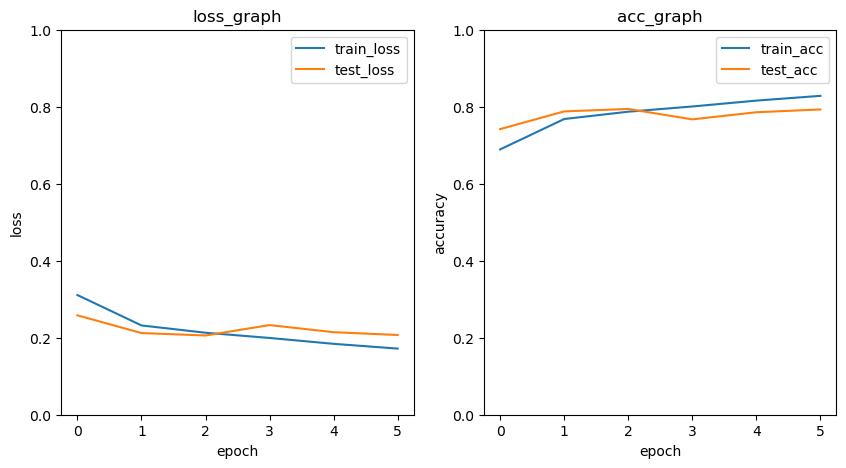

epoch: 7/1000 Step: 337 dice_loss : 0.1570 dice_score: 0.8430: 100%|██████████| 336/336 [02:32<00:00,  2.21it/s]
test epoch: 7/1000 Step: 85 dice_loss : 0.2084  dice_score: 0.7916: 100%|██████████| 84/84 [00:10<00:00,  8.06it/s]
epoch: 8/1000 Step: 337 dice_loss : 0.1470 dice_score: 0.8530: 100%|██████████| 336/336 [02:35<00:00,  2.17it/s]
test epoch: 8/1000 Step: 85 dice_loss : 0.2072  dice_score: 0.7928: 100%|██████████| 84/84 [00:10<00:00,  8.27it/s]
epoch: 9/1000 Step: 337 dice_loss : 0.1357 dice_score: 0.8643: 100%|██████████| 336/336 [02:30<00:00,  2.24it/s]
test epoch: 9/1000 Step: 85 dice_loss : 0.2068  dice_score: 0.7932: 100%|██████████| 84/84 [00:10<00:00,  8.03it/s]
epoch: 10/1000 Step: 337 dice_loss : 0.1261 dice_score: 0.8739: 100%|██████████| 336/336 [02:41<00:00,  2.08it/s]
test epoch: 10/1000 Step: 85 dice_loss : 0.2081  dice_score: 0.7919: 100%|██████████| 84/84 [00:10<00:00,  7.77it/s]
epoch: 11/1000 Step: 337 dice_loss : 0.1191 dice_score: 0.8809: 100%|██████████| 3

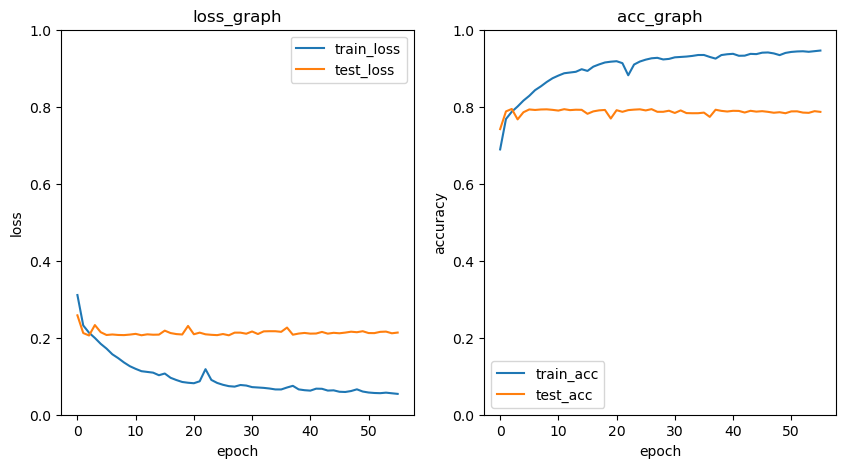

epoch: 57/1000 Step: 337 dice_loss : 0.0593 dice_score: 0.9407: 100%|██████████| 336/336 [02:31<00:00,  2.22it/s]
test epoch: 57/1000 Step: 85 dice_loss : 0.2202  dice_score: 0.7798: 100%|██████████| 84/84 [00:10<00:00,  8.00it/s]
epoch: 58/1000 Step: 337 dice_loss : 0.0573 dice_score: 0.9427: 100%|██████████| 336/336 [02:32<00:00,  2.21it/s]
test epoch: 58/1000 Step: 85 dice_loss : 0.2112  dice_score: 0.7888: 100%|██████████| 84/84 [00:10<00:00,  7.95it/s]
epoch: 59/1000 Step: 337 dice_loss : 0.0531 dice_score: 0.9469: 100%|██████████| 336/336 [02:33<00:00,  2.18it/s]
test epoch: 59/1000 Step: 85 dice_loss : 0.2153  dice_score: 0.7847: 100%|██████████| 84/84 [00:10<00:00,  8.10it/s]
epoch: 60/1000 Step: 337 dice_loss : 0.0516 dice_score: 0.9484: 100%|██████████| 336/336 [02:32<00:00,  2.20it/s]
test epoch: 60/1000 Step: 85 dice_loss : 0.2126  dice_score: 0.7874: 100%|██████████| 84/84 [00:10<00:00,  7.86it/s]
epoch: 61/1000 Step: 337 dice_loss : 0.0513 dice_score: 0.9487: 100%|███████

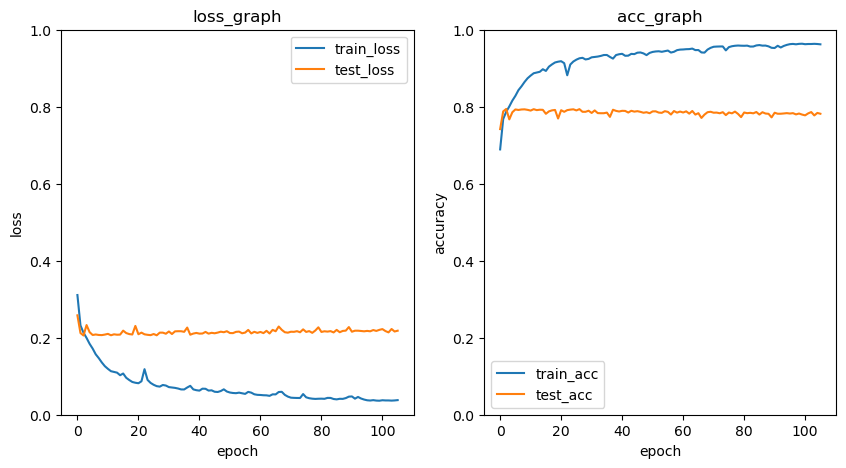

epoch: 107/1000 Step: 337 dice_loss : 0.0469 dice_score: 0.9531: 100%|██████████| 336/336 [02:31<00:00,  2.22it/s]
test epoch: 107/1000 Step: 85 dice_loss : 0.2156  dice_score: 0.7844: 100%|██████████| 84/84 [00:10<00:00,  8.00it/s]
epoch: 108/1000 Step: 337 dice_loss : 0.0402 dice_score: 0.9598: 100%|██████████| 336/336 [02:30<00:00,  2.24it/s]
test epoch: 108/1000 Step: 85 dice_loss : 0.2170  dice_score: 0.7830: 100%|██████████| 84/84 [00:10<00:00,  7.91it/s]
epoch: 109/1000 Step: 337 dice_loss : 0.0356 dice_score: 0.9644: 100%|██████████| 336/336 [02:35<00:00,  2.16it/s]
test epoch: 109/1000 Step: 85 dice_loss : 0.2190  dice_score: 0.7810: 100%|██████████| 84/84 [00:10<00:00,  7.90it/s]
epoch: 110/1000 Step: 337 dice_loss : 0.0344 dice_score: 0.9656: 100%|██████████| 336/336 [02:34<00:00,  2.18it/s]
test epoch: 110/1000 Step: 85 dice_loss : 0.2181  dice_score: 0.7819: 100%|██████████| 84/84 [00:10<00:00,  7.92it/s]
epoch: 111/1000 Step: 337 dice_loss : 0.0345 dice_score: 0.9655: 100

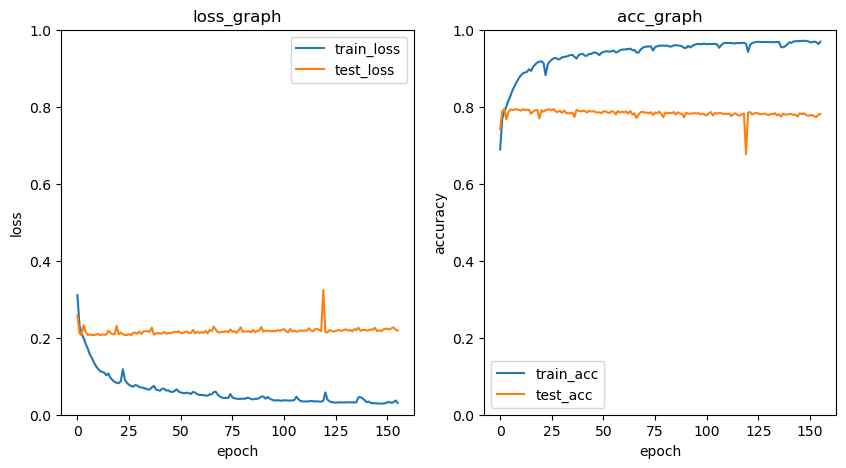

epoch: 157/1000 Step: 337 dice_loss : 0.0289 dice_score: 0.9711: 100%|██████████| 336/336 [02:30<00:00,  2.24it/s]
test epoch: 157/1000 Step: 85 dice_loss : 0.2188  dice_score: 0.7812: 100%|██████████| 84/84 [00:10<00:00,  7.97it/s]
epoch: 158/1000 Step: 337 dice_loss : 0.0282 dice_score: 0.9718: 100%|██████████| 336/336 [02:33<00:00,  2.19it/s]
test epoch: 158/1000 Step: 85 dice_loss : 0.2200  dice_score: 0.7800: 100%|██████████| 84/84 [00:10<00:00,  7.99it/s]
epoch: 159/1000 Step: 337 dice_loss : 0.0285 dice_score: 0.9715: 100%|██████████| 336/336 [02:30<00:00,  2.23it/s]
test epoch: 159/1000 Step: 85 dice_loss : 0.2226  dice_score: 0.7774: 100%|██████████| 84/84 [00:10<00:00,  8.10it/s]
epoch: 160/1000 Step: 337 dice_loss : 0.0337 dice_score: 0.9663: 100%|██████████| 336/336 [02:28<00:00,  2.26it/s]
test epoch: 160/1000 Step: 85 dice_loss : 0.2341  dice_score: 0.7659: 100%|██████████| 84/84 [00:10<00:00,  8.05it/s]
epoch: 161/1000 Step: 337 dice_loss : 0.0355 dice_score: 0.9645: 100

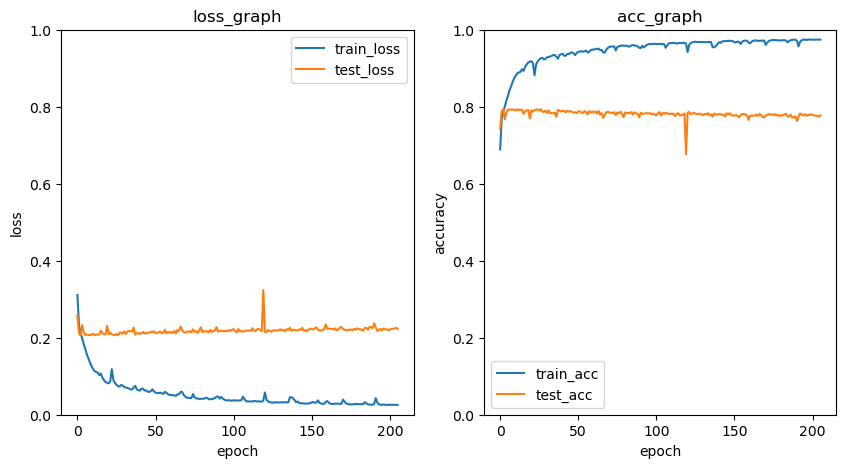

epoch: 207/1000 Step: 337 dice_loss : 0.0381 dice_score: 0.9619: 100%|██████████| 336/336 [02:31<00:00,  2.22it/s]
test epoch: 207/1000 Step: 85 dice_loss : 0.2319  dice_score: 0.7681: 100%|██████████| 84/84 [00:10<00:00,  8.07it/s]
epoch: 208/1000 Step: 337 dice_loss : 0.0332 dice_score: 0.9668: 100%|██████████| 336/336 [02:28<00:00,  2.26it/s]
test epoch: 208/1000 Step: 85 dice_loss : 0.2204  dice_score: 0.7796: 100%|██████████| 84/84 [00:10<00:00,  7.93it/s]
epoch: 209/1000 Step: 337 dice_loss : 0.0269 dice_score: 0.9731: 100%|██████████| 336/336 [02:30<00:00,  2.24it/s]
test epoch: 209/1000 Step: 85 dice_loss : 0.2228  dice_score: 0.7772: 100%|██████████| 84/84 [00:10<00:00,  8.11it/s]
epoch: 210/1000 Step: 337 dice_loss : 0.0278 dice_score: 0.9722: 100%|██████████| 336/336 [02:29<00:00,  2.25it/s]
test epoch: 210/1000 Step: 85 dice_loss : 0.2194  dice_score: 0.7806: 100%|██████████| 84/84 [00:10<00:00,  8.29it/s]
epoch: 211/1000 Step: 337 dice_loss : 0.0277 dice_score: 0.9723: 100

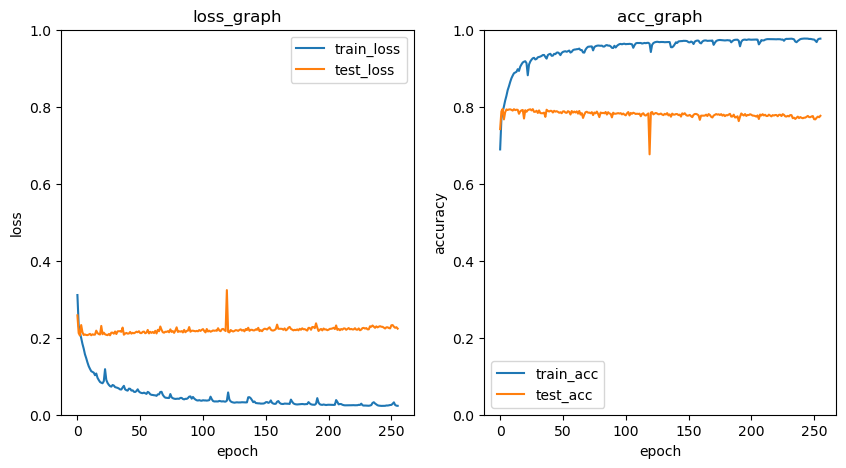

epoch: 257/1000 Step: 337 dice_loss : 0.0228 dice_score: 0.9772: 100%|██████████| 336/336 [02:29<00:00,  2.24it/s]
test epoch: 257/1000 Step: 85 dice_loss : 0.2308  dice_score: 0.7692: 100%|██████████| 84/84 [00:10<00:00,  8.10it/s]
epoch: 258/1000 Step: 337 dice_loss : 0.0229 dice_score: 0.9771: 100%|██████████| 336/336 [02:31<00:00,  2.22it/s]
test epoch: 258/1000 Step: 85 dice_loss : 0.2290  dice_score: 0.7710: 100%|██████████| 84/84 [00:10<00:00,  8.08it/s]
epoch: 259/1000 Step: 337 dice_loss : 0.0250 dice_score: 0.9750: 100%|██████████| 336/336 [02:29<00:00,  2.25it/s]
test epoch: 259/1000 Step: 85 dice_loss : 0.2348  dice_score: 0.7652: 100%|██████████| 84/84 [00:10<00:00,  8.08it/s]
epoch: 260/1000 Step: 337 dice_loss : 0.0282 dice_score: 0.9718: 100%|██████████| 336/336 [02:29<00:00,  2.25it/s]
test epoch: 260/1000 Step: 85 dice_loss : 0.2297  dice_score: 0.7703: 100%|██████████| 84/84 [00:10<00:00,  8.00it/s]
epoch: 261/1000 Step: 337 dice_loss : 0.0253 dice_score: 0.9747: 100

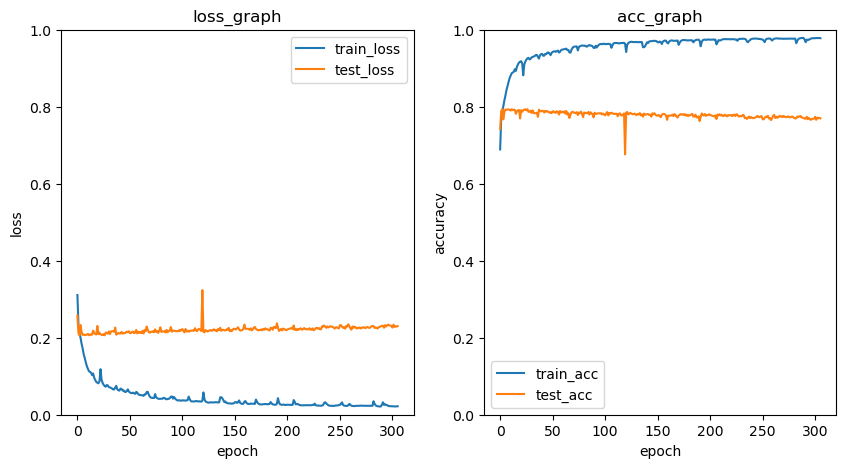

epoch: 307/1000 Step: 337 dice_loss : 0.0220 dice_score: 0.9780: 100%|██████████| 336/336 [02:28<00:00,  2.26it/s]
test epoch: 307/1000 Step: 85 dice_loss : 0.2291  dice_score: 0.7709: 100%|██████████| 84/84 [00:10<00:00,  8.17it/s]
epoch: 308/1000 Step: 337 dice_loss : 0.0218 dice_score: 0.9782: 100%|██████████| 336/336 [02:29<00:00,  2.25it/s]
test epoch: 308/1000 Step: 85 dice_loss : 0.2310  dice_score: 0.7690: 100%|██████████| 84/84 [00:10<00:00,  8.01it/s]
epoch: 309/1000 Step: 337 dice_loss : 0.0218 dice_score: 0.9782: 100%|██████████| 336/336 [02:30<00:00,  2.24it/s]
test epoch: 309/1000 Step: 85 dice_loss : 0.2290  dice_score: 0.7710: 100%|██████████| 84/84 [00:11<00:00,  7.40it/s]
epoch: 310/1000 Step: 337 dice_loss : 0.0216 dice_score: 0.9784: 100%|██████████| 336/336 [02:29<00:00,  2.24it/s]
test epoch: 310/1000 Step: 85 dice_loss : 0.2311  dice_score: 0.7689: 100%|██████████| 84/84 [00:10<00:00,  7.91it/s]
epoch: 311/1000 Step: 337 dice_loss : 0.0220 dice_score: 0.9780: 100

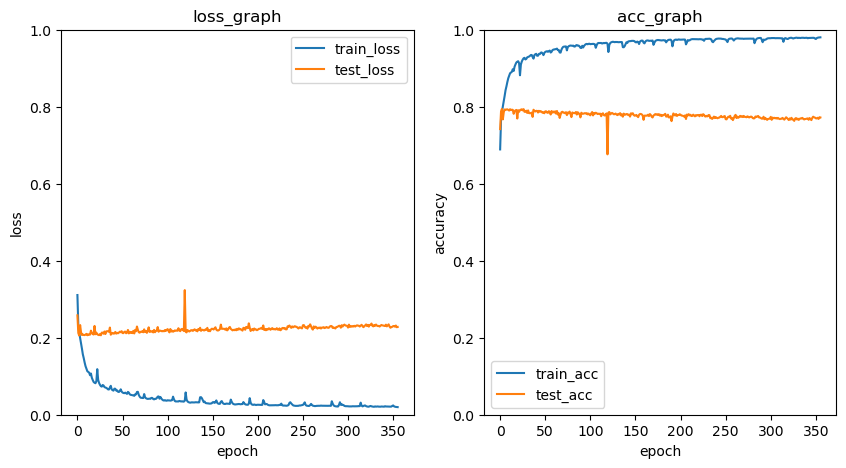

epoch: 357/1000 Step: 337 dice_loss : 0.0196 dice_score: 0.9804: 100%|██████████| 336/336 [02:30<00:00,  2.24it/s]
test epoch: 357/1000 Step: 85 dice_loss : 0.2281  dice_score: 0.7719: 100%|██████████| 84/84 [00:10<00:00,  8.12it/s]
epoch: 358/1000 Step: 337 dice_loss : 0.0198 dice_score: 0.9802: 100%|██████████| 336/336 [02:29<00:00,  2.25it/s]
test epoch: 358/1000 Step: 85 dice_loss : 0.2294  dice_score: 0.7706: 100%|██████████| 84/84 [00:10<00:00,  8.03it/s]
epoch: 359/1000 Step: 337 dice_loss : 0.0198 dice_score: 0.9802: 100%|██████████| 336/336 [02:28<00:00,  2.26it/s]
test epoch: 359/1000 Step: 85 dice_loss : 0.2312  dice_score: 0.7688: 100%|██████████| 84/84 [00:10<00:00,  8.13it/s]
epoch: 360/1000 Step: 337 dice_loss : 0.0198 dice_score: 0.9802: 100%|██████████| 336/336 [02:28<00:00,  2.26it/s]
test epoch: 360/1000 Step: 85 dice_loss : 0.2276  dice_score: 0.7724: 100%|██████████| 84/84 [00:10<00:00,  8.39it/s]
epoch: 361/1000 Step: 337 dice_loss : 0.0198 dice_score: 0.9802: 100

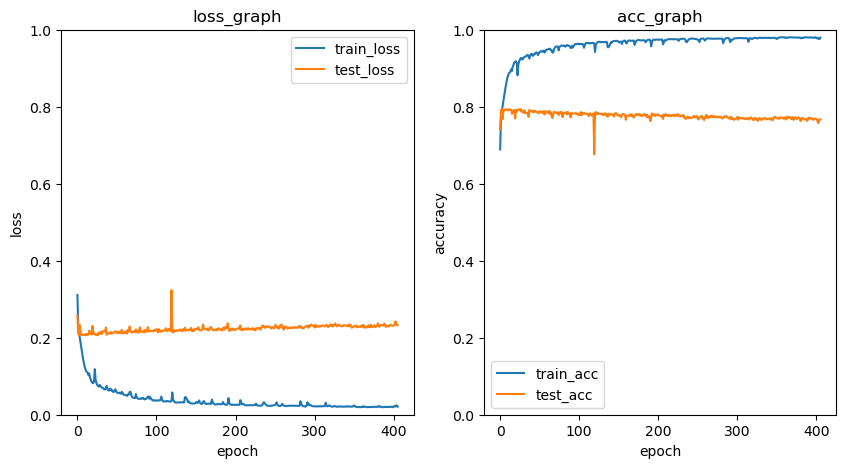

epoch: 407/1000 Step: 337 dice_loss : 0.0199 dice_score: 0.9801: 100%|██████████| 336/336 [03:06<00:00,  1.80it/s]
test epoch: 407/1000 Step: 85 dice_loss : 0.2295  dice_score: 0.7705: 100%|██████████| 84/84 [00:13<00:00,  6.39it/s]
epoch: 408/1000 Step: 337 dice_loss : 0.0196 dice_score: 0.9804: 100%|██████████| 336/336 [03:05<00:00,  1.81it/s]
test epoch: 408/1000 Step: 85 dice_loss : 0.2327  dice_score: 0.7673: 100%|██████████| 84/84 [00:13<00:00,  6.39it/s]
epoch: 409/1000 Step: 337 dice_loss : 0.0193 dice_score: 0.9807: 100%|██████████| 336/336 [03:05<00:00,  1.81it/s]
test epoch: 409/1000 Step: 85 dice_loss : 0.2315  dice_score: 0.7685: 100%|██████████| 84/84 [00:19<00:00,  4.27it/s]
epoch: 410/1000 Step: 337 dice_loss : 0.0193 dice_score: 0.9807: 100%|██████████| 336/336 [03:03<00:00,  1.83it/s]
test epoch: 410/1000 Step: 85 dice_loss : 0.2289  dice_score: 0.7711: 100%|██████████| 84/84 [00:13<00:00,  6.26it/s]
epoch: 411/1000 Step: 337 dice_loss : 0.0190 dice_score: 0.9810: 100

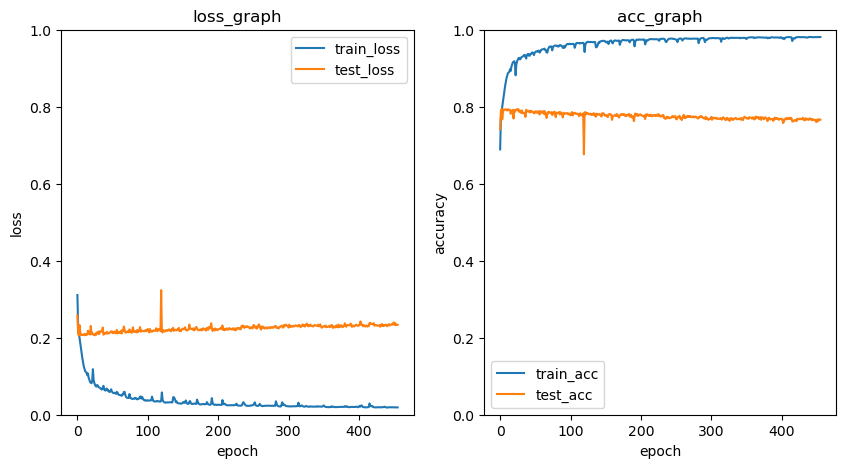

epoch: 457/1000 Step: 337 dice_loss : 0.0190 dice_score: 0.9810: 100%|██████████| 336/336 [02:29<00:00,  2.25it/s]
test epoch: 457/1000 Step: 85 dice_loss : 0.2364  dice_score: 0.7636: 100%|██████████| 84/84 [00:10<00:00,  8.12it/s]
epoch: 458/1000 Step: 337 dice_loss : 0.0190 dice_score: 0.9810: 100%|██████████| 336/336 [02:30<00:00,  2.24it/s]
test epoch: 458/1000 Step: 85 dice_loss : 0.2315  dice_score: 0.7685: 100%|██████████| 84/84 [00:10<00:00,  8.01it/s]
epoch: 459/1000 Step: 337 dice_loss : 0.0189 dice_score: 0.9811: 100%|██████████| 336/336 [02:29<00:00,  2.24it/s]
test epoch: 459/1000 Step: 85 dice_loss : 0.2313  dice_score: 0.7687: 100%|██████████| 84/84 [00:10<00:00,  8.02it/s]
epoch: 460/1000 Step: 337 dice_loss : 0.0191 dice_score: 0.9809: 100%|██████████| 336/336 [02:29<00:00,  2.24it/s]
test epoch: 460/1000 Step: 85 dice_loss : 0.2319  dice_score: 0.7681: 100%|██████████| 84/84 [00:10<00:00,  7.77it/s]
epoch: 461/1000 Step: 337 dice_loss : 0.0254 dice_score: 0.9746: 100

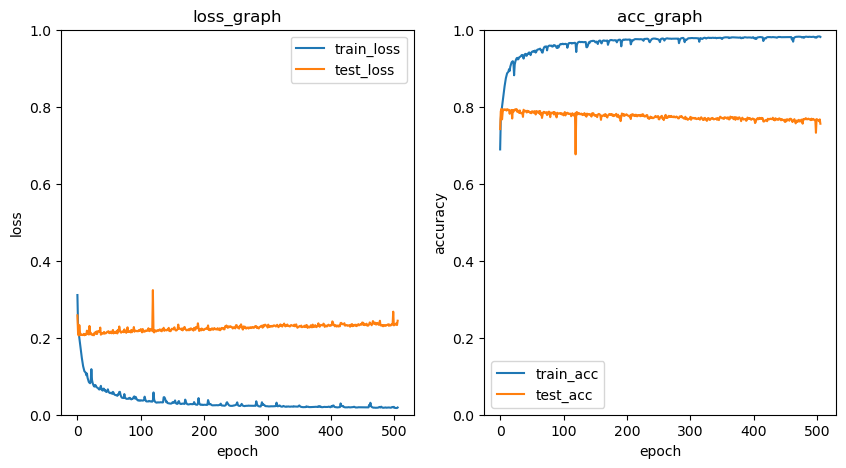

epoch: 507/1000 Step: 337 dice_loss : 0.0281 dice_score: 0.9719: 100%|██████████| 336/336 [02:30<00:00,  2.24it/s]
test epoch: 507/1000 Step: 85 dice_loss : 0.2338  dice_score: 0.7662: 100%|██████████| 84/84 [00:10<00:00,  7.94it/s]
epoch: 508/1000 Step: 337 dice_loss : 0.0196 dice_score: 0.9804: 100%|██████████| 336/336 [02:29<00:00,  2.24it/s]
test epoch: 508/1000 Step: 85 dice_loss : 0.2309  dice_score: 0.7691: 100%|██████████| 84/84 [00:10<00:00,  7.98it/s]
epoch: 509/1000 Step: 337 dice_loss : 0.0181 dice_score: 0.9819: 100%|██████████| 336/336 [02:29<00:00,  2.25it/s]
test epoch: 509/1000 Step: 85 dice_loss : 0.2336  dice_score: 0.7664: 100%|██████████| 84/84 [00:10<00:00,  8.17it/s]
epoch: 510/1000 Step: 337 dice_loss : 0.0175 dice_score: 0.9825: 100%|██████████| 336/336 [02:29<00:00,  2.24it/s]
test epoch: 510/1000 Step: 85 dice_loss : 0.2312  dice_score: 0.7688: 100%|██████████| 84/84 [00:10<00:00,  7.87it/s]
epoch: 511/1000 Step: 337 dice_loss : 0.0170 dice_score: 0.9830: 100

KeyboardInterrupt: 

In [5]:
train_loss_list=[]
val_loss_list=[]
train_acc_list=[]
val_acc_list=[]
MIN_loss=5000
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=2e-4)
metrics = defaultdict(float)
for epoch in range(1000):
    train=tqdm(train_dataloader)
    count=0
    running_loss = 0.0
    acc_loss=0
    for x, y in train:
        model.train()
        y = y.to(device).float()
        count+=1
        x=x.to(device).float()
        optimizer.zero_grad()  # optimizer zero 로 초기화
        predict = model(x).to(device)
        cost = dice_loss(predict, y) # cost 구함
        acc=1-cost.item()
        cost.backward() # cost에 대한 backward 구함
        optimizer.step() 
        running_loss += cost.item()
        acc_loss+=acc
        y = y.to('cpu')

        x=x.to('cpu')
        train.set_description(f"epoch: {epoch+1}/{1000} Step: {count+1} dice_loss : {running_loss/count:.4f} dice_score: {1-running_loss/count:.4f}")
    train_loss_list.append((running_loss/count))
    train_acc_list.append((acc_loss/count))
#test
    val=tqdm(test_dataloader)
    model.eval()
    count=0
    val_running_loss=0.0
    acc_loss=0
    with torch.no_grad():
        for x, y in val:
            y = y.to(device).float()
            count+=1
            x=x.to(device).float()
            
            predict = model(x).to(device)
            cost = dice_loss(predict, y) # cost 구함
            acc=1-cost.item()
            val_running_loss+=cost.item()
            acc_loss+=acc
            y = y.to('cpu')
            x=x.to('cpu')
            val.set_description(f"test epoch: {epoch+1}/{1000} Step: {count+1} dice_loss : {val_running_loss/count:.4f}  dice_score: {1-val_running_loss/count:.4f}")
        val_loss_list.append((val_running_loss/count))
        val_acc_list.append((acc_loss/count))
        
    if MIN_loss>(val_running_loss/count):
        torch.save(model.state_dict(), '../../model/areaSeg/BRNT_callback.pt')
        MIN_loss=(val_running_loss/count)
        
    if epoch%50==5:
        plt.figure(figsize=(10,5))
        plt.subplot(1, 2, 1) 
        plt.title('loss_graph')
        plt.plot(np.arange(epoch+1),train_loss_list,label='train_loss')
        plt.plot(np.arange(epoch+1),val_loss_list,label='test_loss')
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.ylim([0, 1]) 
        plt.legend()
        plt.subplot(1, 2, 2)  
        plt.title('acc_graph')
        plt.plot(np.arange(epoch+1),train_acc_list,label='train_acc')
        plt.plot(np.arange(epoch+1),val_acc_list,label='test_acc')
        plt.xlabel('epoch')
        plt.ylabel('accuracy')
        plt.ylim([0, 1]) 
        plt.legend()
        plt.show()
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1) 
plt.title('loss_graph')
plt.plot(np.arange(epoch+1),train_loss_list,label='train_loss')
plt.plot(np.arange(epoch+1),val_loss_list,label='test_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.ylim([0, 1]) 
plt.legend()
plt.subplot(1, 2, 2)  
plt.title('acc_graph')
plt.plot(np.arange(epoch+1),train_acc_list,label='train_acc')
plt.plot(np.arange(epoch+1),val_acc_list,label='test_acc')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.ylim([0, 1]) 
plt.legend()
plt.show()
print('batch size= 2')
print('image size= 1024,1024')
print('learning rate= 2e-4')